In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, train_test_split
from sklearn.metrics import precision_score,f1_score, accuracy_score, classification_report,confusion_matrix,classification_report

from sklearn.utils import shuffle
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle
from sklearn.metrics import confusion_matrix
# importing sys
import sys
# adding helper_func to the system path
sys.path.insert(0, '../helper_functions/')
# importing actual functions
from helper_functions import preds_N_cm,plot_xgb_importance

#from oversampler_funtion import over_sampler ### NEED TO IMPORT
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_columns", 100)

xgb.__version__

'1.6.0'

In [21]:
building = pd.read_csv("../../Data/Complete_N_Cleaned.csv")
building.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,120101000011,12,1207,120703,1,1,9,288,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,1,0,0,0,damaged_used_in_risk,3,major_repair,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,1,1,15,364,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,1,0,0,0,damaged_repaired_and_used,5,reconstruction,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,1,1,20,384,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,0,0,0,0,damaged_repaired_and_used,2,minor_repair,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
3,120101000041,12,1207,120703,1,1,20,312,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,0,0,0,0,damaged_repaired_and_used,2,minor_repair,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
4,120101000051,12,1207,120703,1,1,30,308,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,0,0,0,0,damaged_repaired_and_used,1,minor_repair,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0


In [22]:
print('confirming no nulls: ',building.isnull().sum().sum())
building.dtypes

confirming no nulls:  0


building_id                                 int64
district_id                                 int64
vdcmun_id                                   int64
ward_id                                     int64
count_floors_pre_eq                         int64
count_floors_post_eq                        int64
age_building                                int64
plinth_area_sq_ft                           int64
height_ft_pre_eq                            int64
height_ft_post_eq                           int64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud                int64
has_superstructure_mud_mortar_stone         int64
has_superstructure_stone_flag               int64


In [23]:
# prepping original data to dummify
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical = ['object']
numdf = building.copy().select_dtypes(include=numerics)
catdf = building.copy().select_dtypes(include=categorical)
#catdf
catdf.head()

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,technical_solution_proposed,legal_ownership_status
0,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_used_in_risk,major_repair,private
1,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,reconstruction,private
2,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private
3,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private
4,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private


In [24]:
# will dummify these to pass into models
dummified_1 = pd.get_dummies(data=catdf,drop_first=True) 
dummified_1 = pd.concat([numdf,dummified_1],axis=1)
print(dummified_1.shape)
dummified_1.head()

(762106, 72)


,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_moderate_slope,land_surface_condition_steep_slope,foundation_type_cement_stone_brick,foundation_type_mud_mortar_stone_brick,foundation_type_other,foundation_type_rc,roof_type_bamboo_timber_light_roof,roof_type_rcc_rb_rbc,ground_floor_type_mud,ground_floor_type_other,ground_floor_type_rc,ground_floor_type_timber,other_floor_type_rcc_rb_rbc,other_floor_type_timber_bamboo_mud,other_floor_type_timber_planck,position_not_attached,plan_configuration_e_shape,plan_configuration_h_shape,plan_configuration_l_shape,plan_configuration_multi_projected,plan_configuration_others,plan_configuration_rectangular,plan_configuration_square,plan_configuration_t_shape,plan_configuration_u_shape,condition_post_eq_damaged_not_used,condition_post_eq_damaged_repaired_and_used,condition_post_eq_damaged_rubble_clear,condition_post_eq_damaged_rubble_clear_new_building_built,condition_post_eq_damaged_rubble_unclear,condition_post_eq_damaged_used_in_risk,condition_post_eq_not_damaged,technical_solution_proposed_minor_repair,technical_solution_proposed_no_need,technical_solution_proposed_reconstruction,legal_ownership_status_other,legal_ownership_status_private,legal_ownership_status_public
0,120101000011,12,1207,120703,1,1,9,288,9,9,0,1,0,0,0,0,0,1,0,0,0,3,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,120101000021,12,1207,120703,1,1,15,364,9,9,0,1,0,0,0,0,0,1,0,0,0,5,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,120101000031,12,1207,120703,1,1,20,384,9,9,0,1,0,0,0,0,0,0,0,0,0,2,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
3,120101000041,12,1207,120703,1,1,20,312,9,9,0,1,0,0,0,0,0,0,0,0,0,2,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
4,120101000051,12,1207,120703,1,1,30,308,9,9,0,1,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [25]:
# prepping my training and testing batches double checking class balances
X = dummified_1.drop(columns = ['building_id','damage_grade']) 
y = dummified_1['damage_grade']-1
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)
print(y_test.unique())
y_test.value_counts(normalize=True) # double checking that it was stratified 

[3 0 4 1 2]


4    0.361865
3    0.241231
2    0.178993
1    0.114493
0    0.103418
Name: damage_grade, dtype: float64

#### Important Note: I had to alter my class from 1-5 to 0-4 for the classifier below.
The baseline is 36%, since we have some pretty imbalanced classes thus our class 4 (grade 5).

In [28]:
%%time 
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=10,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)

CPU times: user 4min 38s, sys: 3.93 s, total: 4min 41s
Wall time: 1min 46s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto',
              random_state=42, reg_alpha=0, ...)

Accuracy: 88.13%

(micro) precision score:  0.8812924152482325         (macro) precision score:  0.8725009399404282
(micro) f1 score:  0.8812924152482325                (macro) f1 score:  0.8653277476604968

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     19704
           1       0.79      0.85      0.82     21814
           2       0.79      0.74      0.76     34103
           3       0.80      0.91      0.85     45961
           4       1.00      0.95      0.97     68945

    accuracy                           0.88    190527
   macro avg       0.87      0.86      0.87    190527
weighted avg       0.89      0.88      0.88    190527



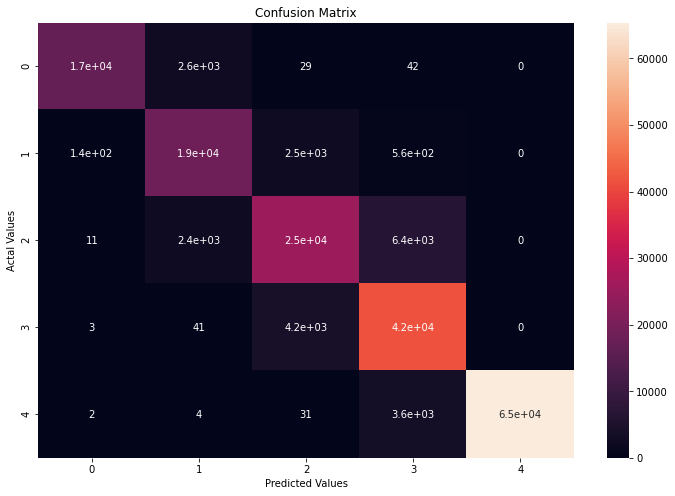

In [29]:
preds_N_cm(model,X_train,y_train,X_test,y_test)   

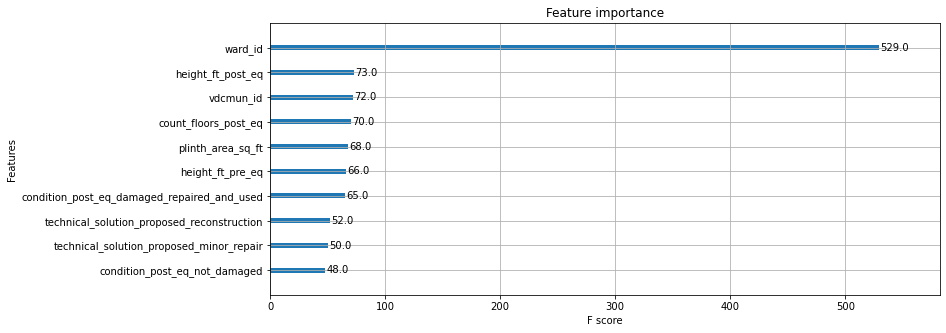

In [30]:
plot_xgb_importance(model,num_features=10)